<a href="https://colab.research.google.com/github/ohmkas/fundos-de-investimentos/blob/main/Carteira_Otima.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install yfinance --upgrade --no-cache-dir
! pip install chart-studio
! pip install cvxopt

     |████████████████████████████████| 6.3MB 3.1MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.59-py2.py3-none-any.whl size=23455 sha256=92f650b07e8952955e6c9272ec2bbc13e63d7046a6ffc1e0a0e9f4830ce4a8a7
  Stored in directory: /tmp/pip-ephem-wheel-cache-6obout_v/wheels/f8/2a/0f/4b5a86e1d52e451757eb6bc17fd899629f0925c777741b6d04
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 71kB 2.0MB/s 


In [2]:
import math
from sympy import *
import yfinance as yf 
yf.pdr_override()
import pandas_datareader.data as web
import plotly
import cufflinks
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np
import cvxopt as opt
from cvxopt import blas, solvers
from plotly.graph_objs import *
import matplotlib.pyplot as plt
import random
from itertools import permutations
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
py.init_notebook_mode(connected=True)
plotly.__version__

'4.4.1'

In [3]:
def consulta_bc(codigo_bcb): #base de dados do banco central
    url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
    df = pd.read_json(url)
    df['data'] = pd.to_datetime(df['data'], dayfirst=True)
    df.set_index('data', inplace=True)
    return (df)
 
#https://www3.bcb.gov.br/sgspub/consultarvalores/telaCvsSelecionarSeries.paint

In [51]:
inicio_analise = '2000-01-01'
tickers = ['BPAC11.SA','CCRO3.SA','CSNA3.SA','CYRE3.SA','IGTA3.SA','ITUB4.SA','LREN3.SA','PRIO3.SA','VALE3.SA','VVAR3.SA'] #ativos que serão combinados


cdi = ((1+(consulta_bc(12).loc[inicio_analise:]/100)).rolling(252).apply(np.prod)-1).iloc[-1] #traz a taxa livre de risco para calculos de sharpe, beta e treynor

print('CDI baixado com sucesso')
ativos = pd.DataFrame()
for i in tickers: #pecorre cada ativo
  ativo = web.get_data_yahoo(i).loc[inicio_analise:]['Adj Close']
  ativo.name = i #insere o nome do ativo na serie
  print(ativo.name)
  ativos = pd.concat([ativos,ativo],axis=1) #junta os ativos
ativos = ativos.dropna() #deixa o inicio de todos os ativos iguais
ativos = ativos.pct_change().dropna() #retornos diarios amostra

CDI baixado com sucesso
[*********************100%***********************]  1 of 1 completed
BPAC11.SA
[*********************100%***********************]  1 of 1 completed
CCRO3.SA
[*********************100%***********************]  1 of 1 completed
CSNA3.SA
[*********************100%***********************]  1 of 1 completed
CYRE3.SA
[*********************100%***********************]  1 of 1 completed
IGTA3.SA
[*********************100%***********************]  1 of 1 completed
ITUB4.SA
[*********************100%***********************]  1 of 1 completed
LREN3.SA
[*********************100%***********************]  1 of 1 completed
PRIO3.SA
[*********************100%***********************]  1 of 1 completed
VALE3.SA
[*********************100%***********************]  1 of 1 completed
VVAR3.SA


In [15]:
print('última data coletada',ativos.index[-1])
ativos.head()

última data coletada 2021-06-04 00:00:00


,BPAC11.SA,CCRO3.SA,CSNA3.SA,CYRE3.SA,IGTA3.SA,ITUB4.SA,LREN3.SA,PRIO3.SA,VALE3.SA,VVAR3.SA
2017-03-01 00:00:00,-0.013736,0.029851,0.011686,-0.006928,-0.003215,-0.001625,0.022700,0.001847,0.013753,0.027228
2017-03-02 00:00:00,0.000000,-0.027912,-0.031353,0.001550,0.011936,-0.010263,-0.013394,-0.026607,-0.051553,-0.057831
2017-03-03 00:00:00,0.044568,0.004970,0.020443,0.017028,-0.007013,0.018210,0.010861,0.033018,0.011443,-0.005115
2017-03-06 00:00:00,0.024000,-0.010989,-0.035893,0.003805,0.012841,-0.003974,0.011895,-0.008646,-0.022627,0.000000
2017-03-07 00:00:00,-0.042709,-0.009445,-0.021645,0.011372,0.006339,-0.016709,-0.017823,-0.007400,-0.005788,-0.002571


Reamostragem > quantidade de retornos possíveis > eficácia

5285 5020


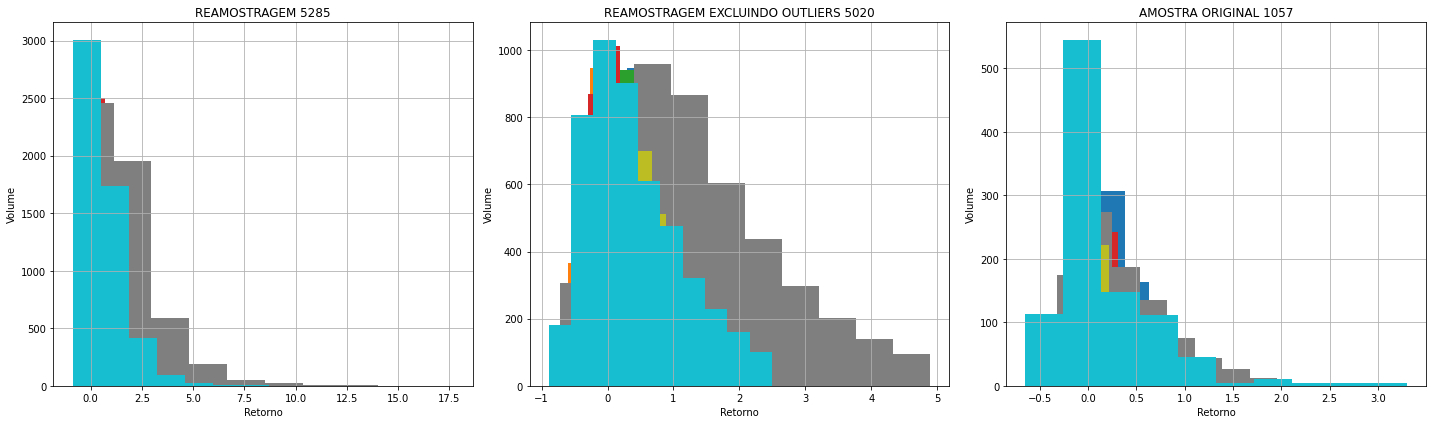

In [52]:
reamostragem=[] #valores da reamostra
n=0 #criterio de tamanho da reamostragem
np.random.seed()
while n < len(ativos)*5: #aumentar amostra em 5x
  aux=((ativos+1).sample(252)).apply(np.prod)-1 #valores reamostrados gerados (retorno anual)
  reamostragem.append(aux)
  n+=1 #criterio logico de contagem

reamostragem = pd.DataFrame(reamostragem) #valores de referencia para calculos de composicao da carteira

reamostragem_sout=pd.DataFrame()
for i in reamostragem: 
  reamostragem_sout[i] = reamostragem.sort_values(by=i,ascending=False).iloc[math.ceil(len(reamostragem)*.05):][i]
  reamostragem_sout[i] = reamostragem_sout[i].iloc[:math.ceil(len(reamostragem)*.95)]
print(len(reamostragem),len(reamostragem_sout)) #informa o antes e depois do tamanho 

hist_sem = pd.DataFrame()
for i in ativos: #percorre os ativos
  hist_sem[i] = (1+ativos[i]).rolling(66).apply(np.prod)-1 #gera um histograma da amostra original com os retornos anuais

fig, axs = plt.subplots(1, 3, sharey=False, tight_layout=True,figsize=(20,6)) #plota o grafico
for i in ativos:
  axs[0].hist(reamostragem[i]) #insere os histogramas
  axs[1].hist(reamostragem_sout[i])
  axs[2].hist(hist_sem[i])

axs[0].set_title('REAMOSTRAGEM '+str(len(reamostragem))) #informa os titulos
axs[1].set_title('REAMOSTRAGEM EXCLUINDO OUTLIERS '+str(len(reamostragem_sout)))
axs[2].set_title('AMOSTRA ORIGINAL '+str(len(ativos)))

for n in list(range(3)):
  axs[n].grid(True)
  axs[n].set_xlabel('Retorno') #eixo x
  axs[n].set_ylabel('Volume') #eixo y

In [53]:
np.random.seed() #gerador 
nsample=100000 #numero de portfólios
nticks=len(tickers) #numero dos tickers
pfolio_returns = []  #retorno do portfólio
pfolio_volatilities = [] #retorno da volatilidade
sharpes=[]
all_weights = np.zeros((nsample, nticks)) #todas as possibilidades possiveis
exp_return = np.zeros(nsample) #fins de cálculo
exp_std = np.zeros(nsample) #fins de cálculo
exp_var = np.zeros(nsample) #fins de cálculo
riskreturn = np.zeros(nsample) #fins de cálculo

for i in range(nsample): #fará n portifolios desejados
    weights = np.random.random(nticks)  #composicao da carteira gerada
    weights = weights/np.sum(weights) #divide ela pela soma para a composição de cada ativo nao passe de 100% 
    
    all_weights[i,:] = weights #salva todos os pesos
    
    exp_return[i]= np.sum(weights * reamostragem_sout.mean()) #Retorno
    exp_var[i] = np.dot(weights.T,np.dot(reamostragem_sout.cov(), weights)) 
    exp_std[i] = np.sqrt(exp_var[i]) #Risco
    
    riskreturn[i]=exp_return[i]/exp_std[i] #Retorno/Risco
    
    pfolio_returns.append(exp_return[i]) #acumula os retornos
    pfolio_volatilities.append(exp_std[i]) #acumula a volatilidade
    sharpes.append((exp_return[i]-cdi)/riskreturn[i]) #acumula os sharpes

pfolio_returns=np.array(pfolio_returns) #transforma em array
pfolio_volatilities=np.array(pfolio_volatilities)
pfolio_sharpes = np.array(sharpes)


composicao = pd.DataFrame(index=tuple(np.around(all_weights,2))) #gera o df da composicao da carteira com a respectiva vol. ret. retorno/risco
composicao['Vol. Portfólio'] = pfolio_volatilities
composicao['Ret. Portfólio'] = pfolio_returns
composicao['Retorno/Risco Portfólio'] = pfolio_returns/pfolio_volatilities
composicao['Sharpe'] = pfolio_sharpes
composicao.sort_values(by='Retorno/Risco Portfólio', ascending=False).iloc[0]

,Vol. Portfólio,Ret. Portfólio,Retorno/Risco Portfólio,Sharpe
"(0.26, 0.01, 0.14, 0.0, 0.01, 0.02, 0.02, 0.27, 0.23, 0.04)",0.530276,0.721683,1.360959,0.514151
"(0.43, 0.02, 0.05, 0.06, 0.01, 0.01, 0.09, 0.2, 0.13, 0.01)",0.500582,0.673925,1.346281,0.484282
"(0.34, 0.05, 0.03, 0.01, 0.01, 0.02, 0.14, 0.24, 0.14, 0.02)",0.497885,0.668872,1.343428,0.481549
"(0.22, 0.01, 0.07, 0.01, 0.02, 0.06, 0.18, 0.23, 0.15, 0.04)",0.465427,0.622516,1.337515,0.449020
"(0.21, 0.0, 0.15, 0.06, 0.04, 0.01, 0.04, 0.21, 0.22, 0.05)",0.475642,0.635872,1.336869,0.459227


retorno/risco:  1.360958586568756 melhor composição


Text((0.26, 0.01, 0.14, 0.0, 0.01, 0.02, 0.02, 0.27, 0.23, 0.04)    0.530276
Name: Vol. Portfólio, dtype: float64, (0.26, 0.01, 0.14, 0.0, 0.01, 0.02, 0.02, 0.27, 0.23, 0.04)    0.741683
Name: Ret. Portfólio, dtype: float64, '(0.26, 0.01, 0.14, 0.0, 0.01, 0.02, 0.02, 0.27, 0.23, 0.04)')

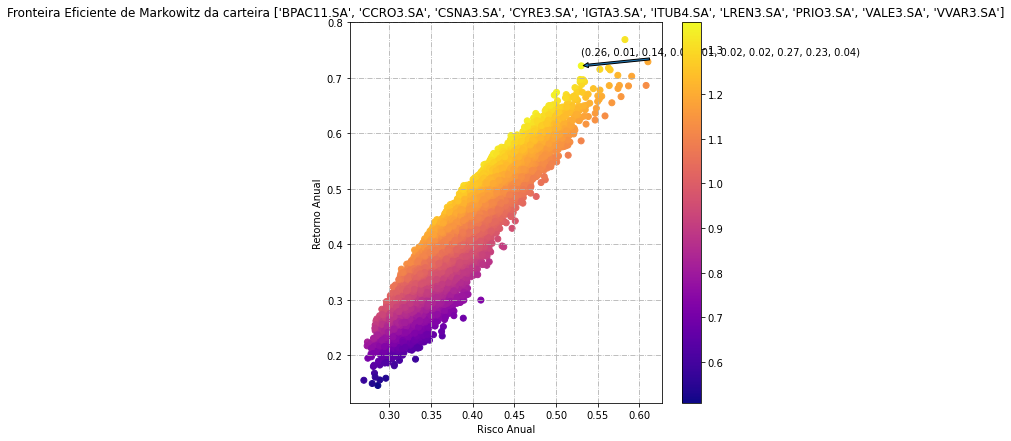

In [70]:
print('retorno/risco: ',composicao['Retorno/Risco Portfólio'].max(),'melhor composição')
fig = plt.figure(figsize=(7,7))
plt.scatter(composicao['Vol. Portfólio'],
            composicao['Ret. Portfólio'],
            c=composicao['Retorno/Risco Portfólio'],
            cmap='plasma',
            )
plt.grid(True,ls='-.')
plt.xlabel('Risco Anual')
plt.ylabel('Retorno Anual')
plt.title('Fronteira Eficiente de Markowitz da carteira '+str(ativos.columns.to_list()))
plt.colorbar()
plt.annotate(composicao['Retorno/Risco Portfólio'].idxmax(),
             (composicao.loc[composicao['Retorno/Risco Portfólio']==composicao['Retorno/Risco Portfólio'].max()]['Vol. Portfólio'],
              composicao.loc[composicao['Retorno/Risco Portfólio']==composicao['Retorno/Risco Portfólio'].max()]['Ret. Portfólio']),
             (composicao.loc[composicao['Retorno/Risco Portfólio']==composicao['Retorno/Risco Portfólio'].max()]['Vol. Portfólio'],
              composicao.loc[composicao['Retorno/Risco Portfólio']==composicao['Retorno/Risco Portfólio'].max()]['Ret. Portfólio']+.02,
              ),arrowprops={'arrowstyle':'simple'})